# ODE Integration: Thermal NO
This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 4 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 11 February 2020.

The objectives of this tutorial are: 1) to show how to write the system of nonlinear ordinary differential equations (ODEs) governing the time evolution of species molar concentrations for a given set of chemical reactions; 2) to show how to solve a system of linear or nonlinear ODEs (an initial value problem) using SciPy's `solve_ivp()` function; and 3) to provide further insight into the formation of nitric oxide (NO), a key regulated pollutant. We will use the thermodynamic properties that are included in gri30.cti, for the purpose of performing an equilibrium calculation.

The reader should be familiar with the material in the previous Notebook (4_1_Chemical_kinetics_Cantera_basics) before working through this Notebook.

## 1. Background and motivation

In Chapter 4 of Turns 4th ed., it is shown how to write an expression for the net chemical production rate of any species involved in a given reaction mechanism, in terms of the rate coefficients for the chemical reactions and the molar concentrations of all species involved in the reactions. The net production rate for species $i$ is denoted as $ \dot \omega _ i$, and has units of molar concentration per unit time (kmol/m^3-s). Also, in the previous tutorial Notebook (4_1_Chemical_kinetics_Cantera_basics), we saw how to access $ \dot \omega _i $ and other reaction-related quantities in Cantera.

Here we consider a gas mixture that contains $N_{spec}$ distinct chemical species, or molecules. For situations where the changes in species molar concentrations are due only to chemical reactions (versus changes in system volume, for example), the time-rate-of-change of molar concentration for species $i$ is given directly by $ \dot \omega _ i $:

$$ \frac{d[X_i]}{dt} = \dot \omega _ i \ , \ i = 1 , \ldots , N_{spec} $$

where $[X_i]$ denotes the molar concentration of species $i$. Given the initial values of the molar concentrations for all species, together with the mixture temperature and pressure, this system of nonlinear ordinary differential equations (ODEs) can (in principle) be integrated in time to determine the time evolution of the molar concentrations of all species involved in the reaction mechanism. In subsequent chapters and tutorial Notebooks, we will see how to do that using predefined objects that are available in Cantera. 

In this tutorial Notebook, we will set up and solve the system of ODEs for a small reaction mechanism "manually", outside of Cantera. The reaction mechanism that we will work with is one that is of significant practical importance. This will provide some practice in writing down the expressions for $ \dot \omega _ i$ for a given set of chemical reactions. It will also show how one can solve an initial-value problem using SciPy's [`solve_ivp()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function. That will be useful in subsequent tutorial Notebooks. 

## 2. The Zeldovich and extended Zeldovich mechanisms for NO formation

Nitric oxide (NO) is a key regulated pollutant that is formed in most combustion processes where air is the oxidizer, and the temperature is sufficiently high. The nitrogen comes from the air, which is approximately 79% $N_2$ on a volume or molar basis. In many practical combustion systems, the following set of two reversible reactions is responsible for most of the NO production. This is called the *thermal* or *Zeldovich* mechanism for NO formation:

$$ O + N_2 \rightleftharpoons NO + N $$
$$ N + O_2 \rightleftharpoons NO + O $$

Sometimes a third reversible reaction is added, in which case the system of three reversible reactions is referred to as the *extended Zeldovich* mechanism:

$$ N + OH \rightleftharpoons NO + H $$

Note that all three reactions are bimolecular in both directions. The Zeldovich and extended Zeldovich mechanisms are discussed in Chapters 4 and 5 of Turns 4th ed., and there is some additional discussion in Chapter 15. Other pathways or mechanisms by which $NO$ and/or $NO_2$ (nitrogen dioxide) can be formed are also discussed in Chapter 5. When one refers to *oxides of nitrogen* or *nitrogen oxides* as a pollutant, that includes both $NO$ and $NO_2$, and is written as $NO_x$, where $NO_x$ is understood to include both species (with $x = $ 1 for $NO$, and $x=$ 2 for $NO_2$). 

Seven species are involved in the extended Zeldovich mechanism: $O$, $N_2$, $NO$, $N$, $O_2$, $OH$, and $H$. The corresponding time-rate-of-change of molar concentration for each of the seven species is obtained by summing the contributions from each forward and each reverse reaction. For the case where the changes in species molar concentrations are due only to chemical reactions:

$$ \frac{d[O]}{dt} = -k_{1f} [O] [N_2] + k_{1r} [NO] [N] + k_{2f} [N] [O_2] - k_{2r} [NO] [O]$$
$$ \frac{d[N_2]}{dt} = -k_{1f} [O] [N_2] + k_{1r} [NO] [N] $$
$$ \frac{d[NO]}{dt} = k_{1f} [O] [N_2] - k_{1r} [NO] [N] + k_{2f} [N] [O_2] - k_{2r} [NO] [O] + k_{3f} [N] [OH] - k_{3r} [NO] [H] $$
$$ \frac{d[N]}{dt} = k_{1f} [O] [N_2] - k_{1r} [NO] [N] - k_{2f} [N] [O_2] + k_{2r} [NO] [O] - k_{3f} [N] [OH] + k_{3r} [NO] [H] $$
$$ \frac{d[O_2]}{dt} = - k_{2f} [N] [O_2] + k_{2r} [NO] [O] $$
$$ \frac{d[OH]}{dt} = - k_{3f} [N] [OH] + k_{3r} [NO] [H] $$
$$ \frac{d[H]}{dt} =  k_{3f} [N] [OH] - k_{3r} [NO] [H] $$

Here $ k_{1f} $ denotes the temperature-dependent forward rate constant for the first reaction, $ k_{1r} $ denotes the temperature-dependent reverse rate constant for the first reaction, etc. Normally the forward rate constants for the three reactions would be given using the usual modified Arrhenius form (with three parameters for each reaction), and the reverse rate constant for each reaction would be determined using the forward rate constant and an equilibrium constant. The corresponding system of ODEs for the standard Zeldovich mechanism follows by removing two of the above ODEs (the ones for $d[OH]/dt$ and $d[H]/dt$) and by removing contributions from the third reversible reaction (no $k_{3f}$ or $k_{3r}$ terms).

In addition to providing a compact reaction mechanism that is of significant practical importance, the Zeldovich or extended Zeldovich mechanism also is a good example of how a reaction mechanism can be systematically reduced by invoking appropriate assumptions/simplifications, as discussed in Chapters 4 and 5. In particular, if one ignores the reverse reactions (appropriate if the molar concentration of $NO$ is sufficiently low), assumes that nitrogen atoms $N$ are in steady state, and assumes that $N_2$, $O_2$, $O$, and $OH$ concentrations are at their equilibrium values, then the expression for the time-rate-of-change of $NO$ molar concentration simplifies to:

$$ \frac{d[NO]}{dt} = 2 k_{1f} [O]_{eq} [N_2]_{eq} $$

where $[O]_{eq}$ and $[N_2]_{eq}$ refer to the equilibrium molar concentrations of $O$ and $N_2$, respectively. This will be referred to as the *simplified Zeldovich* mechanism. Alternatively, the term $[O]_{eq}$ can be written in terms of the equlibrium molar concentration of $O_2$ and the equilibrium constant for the reaction $ O_2 \rightleftharpoons 2 O $, as shown in Chapter 4. In this simplified rate expression, only a single elementary rate constant is required.

As we will see later in Chapters 4 and 5, thermal $NO$ formation tends to be a relatively slow process (compared to the primary oxidation of fuel and air to form the major products of combustion) that requires a relatively high temperature (~1800 K). For that reason, as a first approximation it is often reasonable to assume that thermal $NO$ formation begins after the main combustion event has been completed and the major product species compositions correspond to their equilibrium values. Then the above equations for $d[NO]/dt$ (corresponding to the standard Zeldovich, extended Zeldovich, or simplified Zeldovich mechanisms) can be integrated in time to compute the time evolution of the molar concentration of $NO$, with the initial condition $[NO] = 0$ and equilibrium values for the other species molar concentrations. That is what we will do in Sections 4 and 5 below. Before we do that, though, we introduce the approach that we will use to solve the initial-value problem. This will show the key steps required to set up and solve a system of coupled ODEs for a simpler problem (a system of linear ODEs), before moving to the nonlinear system of ODEs that is characteristic of a combustion problem.

## 3. Solution of a linear initial value problem using `solve_ivp()`

Here we show the key steps needed to set up and solve an initial-value problem (i.e., to integrate a system of coupled ODEs in time, starting from a given initial condition) using SciPy's [`solve_ivp()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function. 

In [1]:
# access modules
# note that we do not need Cantera here
# also note that we load the single object "solve_ivp" (the initial-value-problem ODE solver) from scipy.integrate
# then to call this function and place the output into an object named "solution", say, 
#   we can type "solution = solve_ivp(argument1,argument2, . . .)" with no prefix required for "solve_ivp"
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# uncomment the following line for help on "solve_ivp", if you would like to see the details
#help solve_ivp?

In [3]:
# define the system of ODEs to solve
# that is done using a function (here, named "odes") that will be called by the ODE integrator (here, "solve_ivp")

# here there are four coupled linear ODEs that correspond to a simple system
#   of a point mass m that moves in the x-y plane, subject to a constant force
#   with components gx and gy in the x and y directions, respectively
#     x  is the x-direction location of the mass (m)
#     y  is the y-direction location of the mass (m)
#     u  is the x-direction speed of the mass (m/s)
#     v  is the y-direction speed of the mass (m/s)
#     m  is the constant mass (kg)
#     gx is the constant x-direction force (N=kg*m/s^2)
#     gy is the constant y-direction force (N=kg*m/s^2)

# the system of first-order linear ODEs governing this system is then:
#   dx/dt = u
#   dy/dt = v
#   du/dt = gx/m
#   dv/dt = gy/m

# the function "odes" has three arguments:
#   t is the independent variable (time)
#   dvars is an array that holds four dependent variables ([x,y,u,v])
#   parms is an array that holds three constant parameters ([m,gx,gy])

def odes(t,dvars,parms): 
    x, y, u, v = dvars  # unpack dvars into four local values of x, y, u, and v
    m, gx, gy  = parms  # unpack parms into three local values of m, gx, and gy
    f = [ u ,           # specify the array of right-hand sides for the four ODEs
          v ,
          gx/m ,
          gy/m   ]     
    return f            # return the array of right-hand sides to the calling function (the ODE integrator)

In [4]:
# define the time interval over which the solution is to be computed, 
#   and the number of (here, uniformly spaced) time intervals at which the solution is to be evaluated and stored
#   for output and/or plotting
# here t0 is the initial time, tf is the final time, and there are nt uniformly spaced time intervals
t0 =  0. # (s)
tf = 10. # (s)
nt = 101

# define an array containing the time instants at which the solution is to be evaluated; this array will be passed
#   as an argument to the ODE solver
# note the use of NumPy "linspace" to set up the array of time instants here - there are other ways to do this,
#   as we have seen earlier
tarr = np.linspace(t0 , tf, nt) 

# print the time instants at which the solution is to be evaluated
tarr

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

In [5]:
# define an array that contains the initial time and the final time; this array will be passed
#   as an argument to the ODE solver
tspan  = [t0,tf]

# specify the initial conditions at time t=t0
x0 =  1. # (m)
y0 = -1. # (m)
u0 =-10. # (m/s)
v0 = 20. # (m/s)

# load the initial conditions into an array; this array will be passed as an argument to the ODE solver
ics = [x0, y0, u0, v0]

# define the constant problem parameters
param1 =  1. # kg
param2 =  4. # N
param3 = -4. # N

# load the constant problem parameters into an array; this array will be passed as an argument to the ODE solver
params = [param1, param2, param3]

# call the ODE solver
# the function "odes" is passed as the first argument to the ODE solver - we do not call "odes" directly
# note the use of "lambda" to pass the name of the function (here, "odes") and its arguments;
#   this is how we pass the values of the constant parameters through to "odes"
# the two-element array "tspan" is passed as the second argument
# the array of initial conditions is passed as the third argument
# the array of instants in time at which the solution is to be evaluated is passed as the fourth argument using "t_eval"

# several other arguments can be passed to "solve_ivp" to specify the particular algorithm to use to integrate
#   the ODEs, to set numerical tolerances, etc. - you can uncomment the "help" line above to see the available options -
#   here we take the default values for all arguments other than the ones described above
# the default ODE integration method is an explicit Runge-Kutta method;
#   this default method is appropriate for the simple (linear) ODE system that is considered here; a different method
#   must usually be used for combustion chemistry problems - see Section 4 below

# the output returned from "solve_ivp" is directed into an object named "solution" - the name is arbitrary

solution = solve_ivp(lambda t,y:odes(t,y,params),tspan,ics,t_eval=tarr)

# print "solution" - note that it contains information about the solution procedure, in addition to the
#   actual solution to the ODEs
solution

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 26
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])
 t_events: None
        y: array([[ 1.00000000e+00,  2.00000000e-02, -9.20000000e-01,
        -1.82000000e+00, -2.68000000e+00, -3.50000000e+00,


In [6]:
# "solution.t" accesses the time instants at which the solution was evaluated - it is a 1D array

#  here "solution.t" is the same as the array "tarr" that was passed to "solve_ivp" using the "t_eval" argument

# if the "t_eval" argument had not been specified when calling "solve_ivp", then the value of the first element of the array
#   "solution.t" would be equal to the value of "tspan[0]", the value of the last element of the array "solution.t"
#   would be equal to the value of "tspan[1]", and the values of the intermediate elements of the array "solution.t"
#   would be determined internally by the solver

# print "solution.t"
solution.t

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

In [7]:
# "solution.y" accesses the solution to the ODE at the specified time instants - it is a 2D array
# "solution.y[i,j] is the value of the i'th dependent variable at the j'th instant in time
solution.y

array([[ 1.00000000e+00,  2.00000000e-02, -9.20000000e-01,
        -1.82000000e+00, -2.68000000e+00, -3.50000000e+00,
        -4.28000000e+00, -5.02000000e+00, -5.72000000e+00,
        -6.38000000e+00, -7.00000000e+00, -7.58000000e+00,
        -8.12000000e+00, -8.62000000e+00, -9.08000000e+00,
        -9.50000000e+00, -9.88000000e+00, -1.02200000e+01,
        -1.05200000e+01, -1.07800000e+01, -1.10000000e+01,
        -1.11800000e+01, -1.13200000e+01, -1.14200000e+01,
        -1.14800000e+01, -1.15000000e+01, -1.14800000e+01,
        -1.14200000e+01, -1.13200000e+01, -1.11800000e+01,
        -1.10000000e+01, -1.07800000e+01, -1.05200000e+01,
        -1.02200000e+01, -9.88000000e+00, -9.50000000e+00,
        -9.08000000e+00, -8.62000000e+00, -8.12000000e+00,
        -7.58000000e+00, -7.00000000e+00, -6.38000000e+00,
        -5.72000000e+00, -5.02000000e+00, -4.28000000e+00,
        -3.50000000e+00, -2.68000000e+00, -1.82000000e+00,
        -9.20000000e-01,  2.00000000e-02,  1.00000000e+0

In [8]:
# copy the time-dependent solution for each dependent variable to its own 1D array
# this is not really necessary - it is done here to show how the solution is stored in "solution.y"
x = solution.y[0,:]
y = solution.y[1,:]
u = solution.y[2,:]
v = solution.y[3,:]

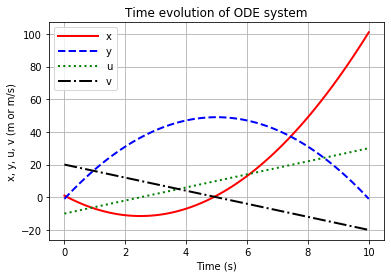

In [9]:
# plot the results
fig, ax = plt.subplots()
ax.plot(solution.t, x, label='x', ls='solid',   color='red',   lw=2)
#ax.plot(solution.t, solution.y[0,:], label='x', ls='solid',   color='red',   lw=2) # equivalent to the previous line
ax.plot(solution.t, y, label='y', ls='dashed',  color='blue',  lw=2)
#ax.plot(solution.t, solution.y[1,:], label='y', ls='dashed',  color='blue',  lw=2) # equivalent to the previous line
ax.plot(solution.t, u, label='u', ls='dotted',  color='green', lw=2)
#ax.plot(solution.t, solution.y[2,:], label='u', ls='dotted',  color='green', lw=2) # equivalent to the previous line
ax.plot(solution.t, v, label='v', ls='dashdot', color='black', lw=2)
#ax.plot(solution.t, solution.y[3,:], label='v', ls='dashdot', color='black', lw=2) # equivalent to the previous line
ax.set(xlabel='Time (s)',
       ylabel='x, y, u, v (m or m/s)',
       title ='Time evolution of ODE system')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("xyuv_vs_t.pdf")

Note that u and v are linear functions of time t, whereas x and y are quadratic functions of t.

Next, we follow the model used for this simple linear problem to set up and solve the systems of nonlinear ODEs that correspond to the Zeldovich and extended Zeldovich NO mechanisms.

## 4. Solution of the nonlinear systems corresponding to the Zeldovich and extended Zeldovich mechanisms

The system of ODEs was given in Section 1 above. As noted there, it is often appropriate (as a first approximation) to consider that NO formation begins after the main combustion event has completed, so that other species are already at their equilibrium concentrations and the temperature is at its final value. To do that here, we compute the equilibrium composition and temperature corresponding to a specified fuel-air reactant mixture using Cantera's `Solution()` object and `equilibrate()`, as we have done in previous tutorial Notebooks. Since $NO$ is one of the species considered in gri30.cti, this will include the equilibrium level of $NO$. However, we will not use the computed equilibrium value of $NO$ here, except to compare that eventually with the result from our time integration.

We also note that the reaction mechanism in GRI-Mech 3.0 includes the three reversible reactions that are considered in the extended Zeldovich mechanism, as well as reactions corresponding to other $NO_x$ pathways. In subsequent tutorial Notebooks, we will use the reaction mechanism in gri30.cti (and other reaction mechanisms) to compute the time evolution of all species (not only those related to $NO$ formation) for specified combustion processes.  

The values of the rate constants used in this section are the values given in the "Oxides of Nitrogen Formation" section of Chapter 5 of Turns 4th ed. There both forward rates and reverse rates are given for each reaction. As discussed in the previous tutorial Notebook and in Chapter 4, in principle one should calculate one of the two rates for each reaction (either the reverse rate or the forward rate) using an equilibrium constant, rather than specifying both rates directly. For the present purposes of illustrating how to integrate the ODEs, this is not an essential point, but it is one that should be kept in mind in interpreting the results.

Finally, we note an important difference between the system of nonlinear ODEs here and the system of linear ODEs considered in Section 3 above. The system of nonlinear equations governing a chemically reacting system is often *stiff*: that is, it is characterized by a wide range of relevant time scales. Not all systems of nonlinear equations are stiff, but those that describe a system of chemical reactions in combustion problems often are stiff. Time scales of chemical reactions will be discussed in a later tutorial Notebook. For now, it is sufficient to note that special algorithms are required to successfully integrate systems of stiff ODEs. For that purpose, we will use an implicit multi-step method based on a backward differentiation formula: the "BDF" method in `solve_ivp()`. We also tighten the internal numerical tolerances used in the ODE solver (denoted as "rtol" and "atol") to values that are smaller than their default values, to ensure sufficiently accurate solutions.

In [10]:
# access modules
# this time, we do import Cantera
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# report Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [11]:
# define an ideal-gas mixture named "gas" using Cantera's "Solution" object and GRI-Mech 3.0
gas = ct.Solution('gri30.cti')

In [12]:
# define a function that computes the time-rate-of-change of the molar concentrations of seven species
#   according the extended Zeldovich mechanism for given values of the six reaction rate constants
#   (i.e., for a given temperature)

def exZelNO(t,dvars,rates):  
# unpack dvars into local values of species molar concentrations
    O, N2, NO, N, O2, OH, H = dvars
# unpack rates into local values of reaction rate constants
    k1f, k1r, k2f, k2r, k3f, k3r = rates    
# specify the array of right-hand sides for the seven ODEs - see Section 1 above
    f = [ -O*N2*k1f + NO*N*k1r + N*O2*k2f - NO*O*k2r ,                         # O
          -O*N2*k1f + NO*N*k1r ,                                               # N2
           O*N2*k1f - NO*N*k1r + N*O2*k2f - NO*O*k2r + N*OH*k3f - NO*H*k3r ,   # NO
           O*N2*k1f - NO*N*k1r - N*O2*k2f + NO*O*k2r - N*OH*k3f + NO*H*k3r ,   # N
                                -N*O2*k2f + NO*O*k2r ,                         # O2
                                                      -N*OH*k3f + NO*H*k3r ,   # OH
                                                       N*OH*k3f - NO*H*k3r   ] # H    
# return the array of right-hand sides to the calling function
    return f

In [13]:
# define a function that computes the time-rate-of-change of the molar concentrations of five species
#   according the standard Zeldovich mechanism for given values of the four reaction rate constants
#   (i.e., for a given temperature)

def ZelNO(t,dvars,rates):   
# unpack dvars into local values of species molar concentrations
    O, N2, NO, N, O2 = dvars
# unpack rates into local values of reaction rate constants
    k1f, k1r, k2f, k2r = rates    
# specify the array of right-hand sides for the five ODEs
    f = [ -O*N2*k1f + NO*N*k1r + N*O2*k2f - NO*O*k2r ,                        # O
          -O*N2*k1f + NO*N*k1r ,                                              # N2
           O*N2*k1f - NO*N*k1r + N*O2*k2f - NO*O*k2r ,                        # NO
           O*N2*k1f - NO*N*k1r - N*O2*k2f + NO*O*k2r ,                        # N
                                -N*O2*k2f + NO*O*k2r   ]                      # O2    
# return the array of right-hand sides to the calling function
    return f

In [14]:
# compute the equilibrium product composition and temperature corresponding to a stoichiometric reactant mixture
#   of propane and air at ambient pressure and temperature, for a constant-pressure adiabatic combustion process

# stoichiometric propane-air reactants, with our usual approximation for air
fuel = 'C3H8'
air  = 'O2:1.0 , N2:3.76'
phi  = 1.0

gas.TP = 300. , ct.one_atm
gas.set_equivalence_ratio(phi,fuel,air)

# print the reactants thermochemical state
gas()


  gri30:

       temperature             300  K
          pressure          101325  Pa
           density         1.19695  kg/m^3
  mean mol. weight         29.4655  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -1.4014e+05       -4.129e+06     J
   internal energy     -2.2479e+05       -6.624e+06     J
           entropy          6893.9        2.031e+05     J/K
    Gibbs function     -2.2083e+06       -6.507e+07     J
 heat capacity c_p          1050.3        3.095e+04     J/K
 heat capacity c_v          768.14        2.263e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2       0.201613         0.218947         -26.2751
                N2       0.758065         0.720709         -23.3101
              C3H8      0.0403226        0.0603447         -77.3418
     [  +50 minor]        

In [15]:
# compute the corresponding constant-pressure adiabatic equilibrium composition and temperature
gas.equilibrate('HP')

# print the equilibrium products thermochemical state
gas()


  gri30:

       temperature         2266.55  K
          pressure          101325  Pa
           density         0.15088  kg/m^3
  mean mol. weight         28.0619  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -1.4014e+05       -3.933e+06     J
   internal energy      -8.117e+05       -2.278e+07     J
           entropy          9704.1        2.723e+05     J/K
    Gibbs function     -2.2135e+07       -6.211e+08     J
 heat capacity c_p          1477.3        4.145e+04     J/K
 heat capacity c_v            1181        3.314e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2      0.0033024      0.000237234         -25.5977
                 H    0.000466879      1.67696e-05         -12.7989
                 O    0.000312885      0.000178391         -17.1756
                O2     0.0

In [16]:
# save the equilibrium temperature and molar concentrations of species that are involved in the extended Zeldovich mechanism
T_eq  = gas.T
O_eq  = gas.concentrations[gas.species_index('O') ]
N2_eq = gas.concentrations[gas.species_index('N2')]
NO_eq = gas.concentrations[gas.species_index('NO')]
N_eq  = gas.concentrations[gas.species_index('N') ]
O2_eq = gas.concentrations[gas.species_index('O2')]
OH_eq = gas.concentrations[gas.species_index('OH')]
H_eq  = gas.concentrations[gas.species_index('H') ]

# print equilibrium temperature and species molar concentrations
T_eq, O_eq, N2_eq, NO_eq, N_eq, O2_eq, OH_eq, H_eq

(2266.5547131631165,
 1.682291111919023e-06,
 0.0038754054598186334,
 1.264904338284341e-05,
 1.2362640668761456e-10,
 3.171787705015069e-05,
 1.732968353253071e-05,
 2.5102722416765395e-06)

In [17]:
# define the time interval over which the solution is to be computed, 
#   and the number of (here, uniformly spaced) time intervals at which the solution is to be evaluated and stored
t0   =  0.       # (s)
tf   =  1.0      # (s)
nt   = 101
tarr = np.linspace(t0 , tf, nt) 

# define an array that contains the initial time and the final time
tspan  = [t0,tf]

# compute the forward and reverse rate constants for the three reversible reactions at the equilibrium temperature,
#   using the rates given in Chapter 5 of Turns 4th ed.
# since all three reactions are bimolecular in both directions, the units of each rate constant
#   are m^3/kmol-s
k1f = 1.8e+11     *np.exp(-38370./T_eq)
k1r = 3.8e+10     *np.exp(  -425./T_eq)
k2f = 1.8e+07*T_eq*np.exp( -4680./T_eq)
k2r = 3.8e+06*T_eq*np.exp(-20820./T_eq)
k3f = 7.1e+10     *np.exp(  -450./T_eq)
k3r = 1.7e+11     *np.exp(-24560./T_eq)

# compute the time evolution of NO molar concentration using the extended Zeldovich mechanism
# here there are seven species and six rate constants
# the initial conditions for all species except NO are taken from the equilibrium calculation;
#   the NO molar concentration is initialized to zero
# the six reaction rate constants are packed into an array named "rates"
# the "BDF" solution algorithm is specified here - that is a method that is appropriate for stiff ODE systems
# tighter values of the solution tolerances (compared to the default values) are also specified
ics   = [O_eq, N2_eq, 0., N_eq, O2_eq, OH_eq, H_eq]
rates = [k1f, k1r, k2f, k2r, k3f, k3r]
soln_exZelNO = solve_ivp(lambda t,y:exZelNO(t,y,rates),tspan,ics,method='BDF',t_eval=tarr,rtol=1.e-12,atol=1.e-12)

# compute the time evolution of NO molar concentration using the standard Zeldovich mechanism
# here there are five species and four rate constants
ics   = [O_eq, N2_eq, 0., N_eq, O2_eq]
rates = [k1f, k1r, k2f, k2r]
soln_ZelNO = solve_ivp(lambda t,y:ZelNO(t,y,rates),tspan,ics,method='BDF',t_eval=tarr,rtol=1.e-12,atol=1.e-12)

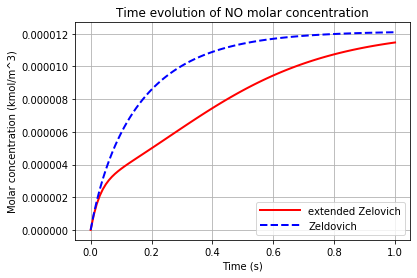

In [18]:
# plot the time evolution of NO molar concentration according to two mechanisms
fig, ax = plt.subplots()
ax.plot(soln_exZelNO.t, soln_exZelNO.y[2,:], label='extended Zelovich', ls='solid',   color='red',   lw=2)
ax.plot(soln_ZelNO.t  , soln_ZelNO.y  [2,:], label='Zeldovich',         ls='dashed',  color='blue',   lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Molar concentration (kmol/m^3)',
       title ='Time evolution of NO molar concentration')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("NO_vs_t_2mechs.pdf")

In [19]:
# recall the equilibrium molar concentration of NO from "equilibrate"
NO_eq  # (kmol/m^3)

1.264904338284341e-05

We could also look at the time evolution of the other species involved in the reaction mechanisms, but here we are interested mainly in $NO$ formation.

For the present mixture composition, temperature, and pressure, $NO$ formation is slow compared to the times that are available in most practical combustion systems. We will discuss that further as we move through subsequent chapters in Turns 4th ed. and subsequent tutorial Notebooks.

Initially, the time-rates-of-change of $NO$ molar concentration from the Zeldovich and the extended Zeldovich mechanisms are approximately the same. This changes after approximately 0.1 s, at which time the extended Zeldovich formation rate slows. The differences can be attributed to the third reversible reaction that is considered in extended Zeldovich, and to differences in the concentrations of the other species involved in the mechanisms away from their initial equilibrium values as the system evolves in time. To use either mechanism as it is really intended to be used, the NO mechanism should be coupled with a more complete reaction mechanism that includes other reactions by which the other species are generated and consumed (e.g., GRI-Mech 3.0). 

The steady-state (long-time) values of the molar concentrations from the two mechanisms appear to be approaching the equilibrium value. In principle, this should be the case. However, recall that here we have directly specified both the forward and the reverse reaction rates for each reversible reaction, rather than using an equilibrium constant to compute one of the two rates. Moreover, the implied values of the equilibrium constants (ratios of forward to reverse rates for each reaction) may not be consistent with the thermodynamic properties in gri30.cti. For these reasons, we should not expect to see perfect consistency between the steady-state values from our time integration and the equlibrium value from Cantera. Nevertheless, it is gratifying to see that the steady-state and equilibrium values appear to be close.

## 5. An often-used approximation for thermal NO

Here the time evolution of $NO$ molar concentration is computed using the simplified expression given in Section 1. The approximations that have been made to get to this reduced form are given there, and in Chapters 4 and 5 of Turns 4th ed. All other species molar concentrations are assumed to remain constant at their respective equilibrium values.

In [20]:
# define a function that computes the time-rate-of-change of the molar concentration of NO
#   according a simplified form of the Zeldovich mechanism for a given value of one reaction rate constant
#   (i.e., for a given temperature)

def simpZelNO(t,dvars,rate):   
# unpack dvars into local values of species molar concentrations
    O, N2, NO = dvars
# here there is a single rate constant
    k1f = rate   
# specify the array of right-hand sides for the five ODEs
    f = [ 0. ,              # O
          0. ,              # N2
          2.*O*N2*k1f  ]    # NO   
# return the array of right-hand sides to the calling function
    return f

In [21]:
# compute the time evolution of NO molar concentration using the simplified Zeldovich mechanism
# here there are three species and one rate constant
ics  = [O_eq, N2_eq, 0.,]
rate = k1f
soln_simpZelNO = solve_ivp(lambda t,y:simpZelNO(t,y,rate),tspan,ics,method='BDF',t_eval=tarr,rtol=1.e-12,atol=1.e-12)

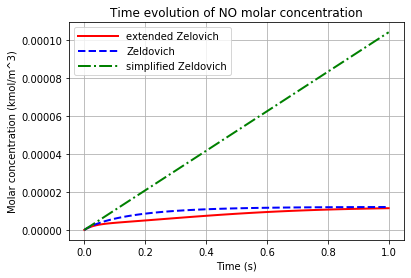

In [22]:
# plot the results
fig, ax = plt.subplots()
ax.plot(soln_ZelNO.t, soln_exZelNO.y  [2,:], label='extended Zelovich',    ls='solid',   color='red',   lw=2)
ax.plot(soln_ZelNO.t, soln_ZelNO.y    [2,:], label='Zeldovich',            ls='dashed',  color='blue',  lw=2)
ax.plot(soln_ZelNO.t, soln_simpZelNO.y[2,:], label='simplified Zeldovich', ls='dashdot', color='green', lw=2)

ax.set(xlabel='Time (s)',
       ylabel='Molar concentration (kmol/m^3)',
       title ='Time evolution of NO molar concentration')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("NO_vs_t_3mechs.pdf")

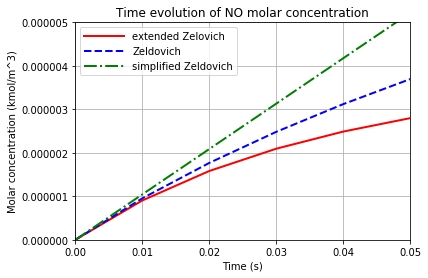

In [23]:
# zoom in on early times
fig, ax = plt.subplots()
ax.plot(soln_ZelNO.t, soln_exZelNO.y  [2,:], label='extended Zelovich',    ls='solid',   color='red',   lw=2)
ax.plot(soln_ZelNO.t, soln_ZelNO.y    [2,:], label='Zeldovich',            ls='dashed',  color='blue',  lw=2)
ax.plot(soln_ZelNO.t, soln_simpZelNO.y[2,:], label='simplified Zeldovich', ls='dashdot', color='green', lw=2)

ax.set(xlim=(0., 0.05),
       ylim=(0.0, 0.000005),
       xlabel='Time (s)',
       ylabel='Molar concentration (kmol/m^3)',
       title ='Time evolution of NO molar concentration')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("NO_vs_t_3mechs_early.pdf")

All three mechanisms give essentially the same initial rate of NO formation.

The molar concentration of $NO$ increases without bound by the simplified mechanism, since there is a single $NO$ formation reaction with no compensating $NO$ consumption reactions, and there is no consumption of the two species involved in the formation reaction ($O$ and $N_2$). The simplified version is really appropriate only for the initial stages of $NO$ formation.

## 6. "Full" NOx chemistry coupled with hydrocarbon-air combustion

In subsequent tutorials, we will use the full reaction mechanism in GRI-Mech 3.0 (and other reaction mechanisms) to compute the time evolution of major and minor species (including $NO$) in constant-pressure and constant-volume combustion systems, and in other combustion systems. There we will use inbuilt Cantera modules to perform the time integration, rather than manually coding the full reaction set. The latter would be doable in principle, but it would be tedious in practice, for this 53-species, 325-reaction mechanism. As noted earlier, GRI-Mech 3.0 includes other $NO_x$-formation pathways beyond thermal NO.